In [ ]:
%tensorflow_version 1.x

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pickle
import numpy as np
import pandas as pd

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Corona_NLP_train.csv to Corona_NLP_train.csv


In [ ]:
data = pd.read_excel("/content/drive/My Drive/Towrut/COVID/data/train.xlsx")

In [ ]:
data.head(
    
)

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
data = data[['comments', 'catagories']]

In [ ]:
data.shape

(5109, 2)

In [ ]:
data.Sentiment.value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [ ]:
map = {
    'c': 'Complain',
    'w': 'Wrong delivery',
    'r': 'Recommended',
    'a': 'Appreciation'
}

data.catagories = data.catagories.map(map)

In [ ]:
data.catagories.value_counts()

Complain          1908
Recommended       1562
Appreciation      1185
Wrong delivery     454
Name: catagories, dtype: int64

## Preprocessing

In [ ]:
%%time
import re
data['texts_prep'] = data.OriginalTweet.apply(lambda x: [i for i in re.sub(r'[^\u0980-\u09E3 A-Za-z]+', ' ', str(x)).split() if len(i) > 1])

CPU times: user 633 ms, sys: 43.3 ms, total: 676 ms
Wall time: 681 ms


In [ ]:
data = data[data.texts_prep.apply(lambda x: len(x)) > 0]

In [ ]:
## Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['target'] = le.fit_transform(data['Sentiment'].copy().tolist())

In [ ]:
data[['Sentiment', 'target']].drop_duplicates(subset=['Sentiment']).sort_values(by=['target']).reset_index(drop=True)

,Sentiment,target
0,Extremely Negative,0
1,Extremely Positive,1
2,Negative,2
3,Neutral,3
4,Positive,4


In [ ]:
# !pip install bnlp_toolkit

In [ ]:
data.head(3)

,OriginalTweet,Sentiment,texts_prep,target
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,"[MeNyrbie, Phil, Gahan, Chrisitv, https, co, i...",3
1,advice Talk to your neighbours family to excha...,Positive,"[advice, Talk, to, your, neighbours, family, t...",4
2,Coronavirus Australia: Woolworths to give elde...,Positive,"[Coronavirus, Australia, Woolworths, to, give,...",4


## Data Partitioning

In [ ]:
X = data['texts_prep']
y = data['target']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.3, random_state=0, stratify=y_val)

print("""Training shape: {}
Validation shape: {}
Testing shape: {}""".format(X_train.shape, X_val.shape, X_test.shape))

Training shape: (28809,)
Validation shape: (8643,)
Testing shape: (3705,)


## Load fastText pre-trained model

In [ ]:
!unzip "/content/drive/My Drive/Munna_Research/Experiment/cc.bn.300.zip" -d /content

Archive:  /content/drive/My Drive/Munna_Research/Experiment/cc.bn.300.zip
  inflating: /content/cc.bn.300.vec  


In [ ]:
from gensim.models import KeyedVectors

path = '/content/cc.bn.300.vec'
fastText_model = KeyedVectors.load_word2vec_format(path, binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## Feature Extraction

In [ ]:
def embedding_vectorizer(fastText_model, docs):
    mean_vecs = []
    for instance in docs:
        vecs = []
        for word in instance:
            if word in fastText_model.vocab:
                vecs.append(fastText_model[word])
            else:
                vecs.append(np.zeros(fastText_model.vector_size))
                
        mean_vecs.append(np.mean(vecs, axis=0))
        
    return mean_vecs

In [ ]:
x_train_vectorized = embedding_vectorizer(fastText_model, X_train)
x_train_vectorized = pd.DataFrame(x_train_vectorized).add_prefix('col_')

In [ ]:
x_val_vectorized = embedding_vectorizer(fastText_model, X_val)
x_val_vectorized = pd.DataFrame(x_val_vectorized).add_prefix('col_')

In [ ]:
x_test_vectorized = embedding_vectorizer(fastText_model, X_test)
x_test_vectorized = pd.DataFrame(x_test_vectorized).add_prefix('col_')

In [ ]:
from keras.utils import to_categorical

y_train_k = to_categorical(y_train, num_classes=5)
y_val_k = to_categorical(y_val, num_classes=5)
y_test_k = to_categorical(y_test, num_classes=5)

In [ ]:
import tensorflow as tf
import random as rn

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import History
from keras.optimizers import Adam, SGD

In [ ]:
np.random.seed(2)
rn.seed(3)

history = History()

model = Sequential()
model.add(Dense(1024, input_dim=256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(5, activation="softmax"))

model.compile(optimizer=Adam(0.0001), loss="categorical_crossentropy", metrics=['accuracy'])
# model.summary()

model.fit(np.array(x_train_vectorized), np.array(y_train_k), 
          validation_data=(np.array(x_val_vectorized), np.array(y_val_k)), 
          epochs=150, 
          batch_size=2000, 
          shuffle=True, 
          callbacks=[history], 
          verbose=True)

Epoch 1/150
15/15 [==============================] - 0s 25ms/step - loss: 1.5928 - accuracy: 0.2544 - val_loss: 1.5609 - val_accuracy: 0.2816
Epoch 2/150
15/15 [==============================] - 0s 12ms/step - loss: 1.5689 - accuracy: 0.2806 - val_loss: 1.5473 - val_accuracy: 0.2965
Epoch 3/150
15/15 [==============================] - 0s 11ms/step - loss: 1.5541 - accuracy: 0.2911 - val_loss: 1.5376 - val_accuracy: 0.3042
Epoch 4/150
15/15 [==============================] - 0s 10ms/step - loss: 1.5461 - accuracy: 0.2982 - val_loss: 1.5303 - val_accuracy: 0.3116
Epoch 5/150
15/15 [==============================] - 0s 10ms/step - loss: 1.5366 - accuracy: 0.3024 - val_loss: 1.5218 - val_accuracy: 0.3219
Epoch 6/150
15/15 [==============================] - 0s 10ms/step - loss: 1.5293 - accuracy: 0.3066 - val_loss: 1.5120 - val_accuracy: 0.3242
Epoch 7/150
15/15 [==============================] - 0s 9ms/step - loss: 1.5195 - accuracy: 0.3122 - val_loss: 1.5001 - val_accuracy: 0.3292
Epoch 8

In [ ]:
# import pickle
# with open("/content/drive/My Drive/Munna_Research/Experiment/model_2.rifat", 'wb') as out_file:
#  pickle.dump(model, out_file)

In [ ]:
# from sklearn.externals import joblib

# # save the model to disk
# filename = "/content/drive/My Drive/Munna_Research/Experiment/model_1.joblib"
# joblib.dump(model, filename)

In [ ]:
# for visualization
his_train_acc = history.history['accuracy']
his_val_acc = history.history['val_accuracy']

his_train_loss = history.history['loss']
his_val_loss = history.history['val_loss']

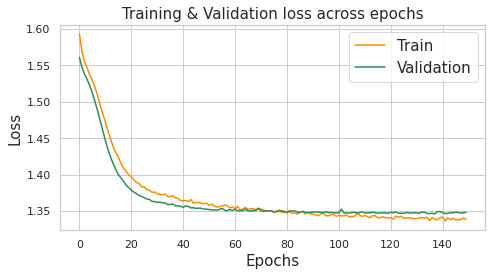

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

fig, ax = plt.subplots(figsize=(7,4))
plt.plot(his_train_loss[:150],'darkorange')
plt.plot(his_val_loss[:150], 'seagreen')

plt.title("Training & Validation loss across epochs",fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=15)
plt.legend(['Train', 'Validation'], fontsize=15 ,loc='upper right')
#plt.xlim(0,45)
#plt.ylim(0.9, 1.5)
plt.tight_layout()
# plt.savefig("multiclass_loss_vs_epochs_fastText_munna.jpg", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
loss, test_accuracy = model.evaluate(np.array(x_test_vectorized), np.array(y_test_k), verbose=0)

In [ ]:
train_accuracy = his_train_acc[-1]
val_accuracy = his_val_acc[-1]

accuracy_table = pd.DataFrame([round(train_accuracy, 2), round(val_accuracy, 2), round(test_accuracy, 2)], 
             index=['Training', 'Validation', 'Test'], 
             columns=['Accuracy'])
accuracy_table

,Accuracy
Training,0.42
Validation,0.42
Test,0.41


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
y_pred = model.predict(np.array(x_test_vectorized))
ac = 0.67 #accuracy_score(y_test_k.argmax(axis=1), y_pred.argmax(axis=1))
print("Test Accuracy:", round(ac, 2))

Test Accuracy: 0.41


In [ ]:
# generate confusion matrix
cm = confusion_matrix(y_test_k.argmax(axis=1), y_pred.argmax(axis=1))

In [ ]:
print("Confusion Matrix: ")
p = pd.DataFrame(cm, 
                 index=[['Actual']*5,list(le.inverse_transform([0, 1, 2, 3,4]))], 
                 columns=[['Predicted']*5,list(le.inverse_transform([0, 1, 2, 3,4]))])

p.style.set_properties(**{'background-color': 'skyblue', 
                          'color': 'black'})

Confusion Matrix: 


In [ ]:
p = pd.DataFrame(cm, 
                 index=list(le.inverse_transform([0, 1, 2, 3,4])), 
                 columns=list(le.inverse_transform([0, 1, 2, 3,4])))

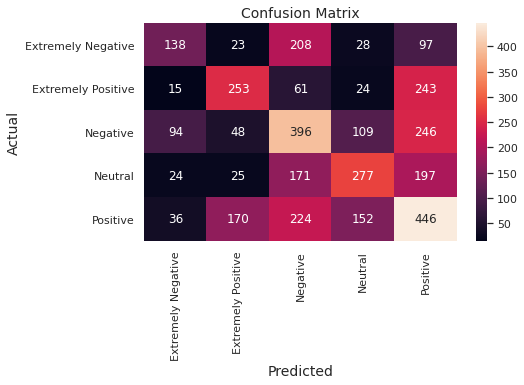

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(7, 4))
sns.set()
f = sns.heatmap(p, annot=True, fmt='d')
plt.title("Confusion Matrix", fontdict={'fontsize': 14})
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual",  fontsize=14)
plt.show()

f.get_figure().savefig("multiclass_confusion_matrix_fastText_munna.jpg", dpi=300, bbox_inches='tight')

In [ ]:
target_names = list(le.inverse_transform([0, 1, 2, 3,4]))
print(classification_report(y_test_k.argmax(axis=1), y_pred.argmax(axis=1), target_names = target_names))

                    precision    recall  f1-score   support

Extremely Negative       0.45      0.28      0.34       494
Extremely Positive       0.49      0.42      0.45       596
          Negative       0.37      0.44      0.41       893
           Neutral       0.47      0.40      0.43       694
          Positive       0.36      0.43      0.40      1028

          accuracy                           0.41      3705
         macro avg       0.43      0.40      0.41      3705
      weighted avg       0.42      0.41      0.41      3705

